In [1]:
import torch
import torch.nn as nn
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [4]:
latent_dim = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)

        return output

In [6]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCELoss().to(device)

lr = 0.0002

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [9]:
import time

n_epochs = 200
sample_interval = 2000
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0)

        real_imgs = imgs.to(device)

        # Optimize generator
        optimizer_G.zero_grad()

        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).to(device)
        generated_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        g_loss.backward()
        optimizer_G.step()

        # Optimize discriminator
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    print(f"[Epoch {epoch:3d}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch   0/200] [D loss: 0.129630] [G loss: 8.644394] [Elapsed time: 22.48s]
[Epoch   1/200] [D loss: 0.108084] [G loss: 3.736743] [Elapsed time: 42.40s]
[Epoch   2/200] [D loss: 0.109270] [G loss: 3.009170] [Elapsed time: 61.89s]
[Epoch   3/200] [D loss: 0.157603] [G loss: 3.262360] [Elapsed time: 82.02s]
[Epoch   4/200] [D loss: 0.117326] [G loss: 3.736861] [Elapsed time: 101.77s]
[Epoch   5/200] [D loss: 0.356916] [G loss: 1.444834] [Elapsed time: 121.51s]
[Epoch   6/200] [D loss: 0.140206] [G loss: 2.922845] [Elapsed time: 141.27s]
[Epoch   7/200] [D loss: 0.165961] [G loss: 3.093904] [Elapsed time: 161.05s]
[Epoch   8/200] [D loss: 0.110605] [G loss: 3.300276] [Elapsed time: 180.64s]
[Epoch   9/200] [D loss: 0.082493] [G loss: 3.381391] [Elapsed time: 200.32s]
[Epoch  10/200] [D loss: 0.101511] [G loss: 3.407068] [Elapsed time: 219.85s]
[Epoch  11/200] [D loss: 0.132645] [G loss: 4.119451] [Elapsed time: 239.43s]
[Epoch  12/200] [D loss: 0.122024] [G loss: 3.514621] [Elapsed time:

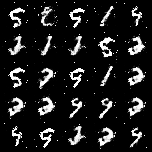

In [27]:
from IPython.display import Image

Image('90000.png')

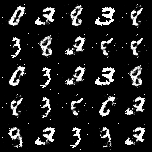

In [26]:
z = torch.normal(mean=0, std=1, size=(25, latent_dim)).to(device)
generated_imgs = generator(z)
save_image(generated_imgs.data, f"result.png", nrow=5, normalize=True)
Image('result.png')